In [20]:
! pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn

emoevent_train_csv_path = '/content/drive/MyDrive/emoevent_train.csv'
emoevent_test_csv_path = '/content/drive/MyDrive/emoevent_test.csv'

emoevent_train = pd.read_csv(emoevent_train_csv_path)
emoevent_test = pd.read_csv(emoevent_test_csv_path)

emoevent_embaug_path = '/content/drive/MyDrive/EmoEvent_embaug_5.csv'
emoevent_data = pd.read_csv(emoevent_embaug_path, encoding='utf-8')

print(emoevent_train.shape)
print(emoevent_data.shape)
emoevent_data.head(15)

(5112, 2)
(25560, 3)


,text,label,paraphrase
0,What is one thing that you can not live withou...,4,1.5550 What is one cimahi thing vachel that yo...
1,What is one thing that you can not live withou...,4,What is one marse thing beakers that you can n...
2,What is one thing that you can not live withou...,4,What is 562.5 one thing that you can kreiensen...
3,What is one thing that you can not live withou...,4,What is muhajaria one originations thing frye ...
4,What is one thing that you can not live withou...,4,What is one something result you could not liv...
5,Hahahhaha bells will be ringing to show solida...,0,Hahahhaha sound hoped blitz be flashing to sho...
6,Hahahhaha bells will be ringing to show solida...,0,gastroenterologist Hahahhaha tinkling. be ring...
7,Hahahhaha bells will be ringing to show solida...,0,Hahahhaha bagpipes will be ringing to show bro...
8,Hahahhaha bells will be ringing to show solida...,0,Hahahhaha carillon enough orelli be ringing to...
9,Hahahhaha bells will be ringing to show solida...,0,Hahahhaha bells clasica will must shushed peal...


Concatenate train and praphased data




In [29]:
parafrase = emoevent_data[['paraphrase', 'label']].copy()
parafrase = parafrase.drop_duplicates()
parafrase.rename(columns={"paraphrase": "tweet","label":"emotion"}, inplace = True)

emoevent_train = emoevent_train.append(parafrase,ignore_index=True)
print(emoevent_train.shape)

(30672, 2)


<ipython-input-29-832523618639>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emoevent_train = emoevent_train.append(parafrase,ignore_index=True)


In [30]:
print(emoevent_train.head(10))

                                               tweet  emotion
0  What is one thing that you can not live withou...        4
1  Hahahhaha bells will be ringing to show solida...        0
2  The Compassionate Civilization Collaborative (...        2
3  They say much was spared, but the images of HA...        5
4  "I may be small. I may be a girl, but I won’t ...        4
5  HASHTAG Today we have begun the definitive pha...        3
6  "The highest education is that which does not ...        4
7  “Hi Friends! Lots of people are making comment...        4
8  HASHTAG election: socialist party HASHTAG decl...        4
9  THAT EPISODE WAS FUCKING EVERYTHING... 🤯🤯🤯🤯🤯 H...        3


In [31]:
train_df = pd.DataFrame(emoevent_train)
train_df.columns = ["text", "labels"]

eval_df = pd.DataFrame(emoevent_test)
eval_df.columns = ["text", "labels"]

In [32]:
import torch
from torch import cuda
import gc

def empty_cache(model, optimizer):
  device = 'cuda' if cuda.is_available() else 'cpu'
  with torch.no_grad():
      torch.cuda.empty_cache()
  gc.collect()

In [33]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, precision_score, recall_score, confusion_matrix

def f1_multiclass(labels, preds):
  return f1_score(labels, preds, average='macro')

def precision_multiclass(labels,preds):
  return precision_score(labels, preds, average='macro')

def recall_multiclass(labels,preds):
  return recall_score(labels, preds, average='macro')

def confusion_matrix_multiclass(labels, preds):
  cm = confusion_matrix(labels, preds)
  return cm

In [34]:
results = []

reps = 3
for i in range(reps):

  model = ClassificationModel(
    "roberta", 
    "roberta-base",
    num_labels=7, 
    args={'num_train_epochs':2,
          'max_seq_length':256,
          'learning_rate':1e-5,
          'overwrite_output_dir': True, 
          'custom_callback': empty_cache
          }
  )

  model.train_model(train_df)

  result, model_outputs, wrong_predictions = model.eval_model(eval_df, 
                                                            acc=sklearn.metrics.accuracy_score,
                                                            f1=f1_multiclass,
                                                            precision=precision_multiclass,
                                                            recall=recall_multiclass,
                                                            confusion_matrix=confusion_matrix_multiclass
                                                            )

  
  results.append({'accuracy': result['acc'], 'f1': result['f1'], 'precision': result['precision'], 'recall': result['recall'], 'confusion_matrix_results': result['confusion_matrix']})

print('accuracy, f1, precision, recall, confusion_matrix:')
for i in results:
  print(i['accuracy'], i['f1'], i['precision'], i['recall'], i['confusion_matrix_results'])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/30672 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/274 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/30672 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/274 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/30672 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/3834 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/274 [00:00<?, ?it/s]

accuracy, f1, precision, recall, confusion_matrix:
0.6143313555454131 0.4825364390390097 0.5065419878039251 0.46368938262893045 [[ 35  40   1   2  38   2   0]
 [ 25  95   3   4  95   3   4]
 [  1   1  14   0  25   3   1]
 [  2   0   0 430 165   5  10]
 [ 34  64  15 156 682  21  20]
 [  0   4   1   8  36  72   4]
 [  3   0   0  13  34   2  18]]
0.6188954815152898 0.48201802882343586 0.507638203219413 0.4651323453753758 [[ 35  42   2   3  34   2   0]
 [ 22 107   4   4  87   3   2]
 [  2   0  13   2  24   3   1]
 [  2   0   0 452 143   6   9]
 [ 31  72   8 172 661  25  23]
 [  2   6   1  10  30  73   3]
 [  3   4   0  14  32   2  15]]
0.6198083067092651 0.5004015012300852 0.5261376887066515 0.48193760820821546 [[ 33  41   2   2  37   2   1]
 [ 15 108   4   3  89   3   7]
 [  0   2  16   1  24   2   0]
 [  3   0   1 424 171   5   8]
 [ 26  63   8 164 681  24  26]
 [  1   7   0   7  31  77   2]
 [  2   3   2  12  30   2  19]]


Confusion matrix with percentages

[[ 35  40   1   2  38   2   0]
 [ 25  95   3   4  95   3   4]
 [  1   1  14   0  25   3   1]
 [  2   0   0 430 165   5  10]
 [ 34  64  15 156 682  21  20]
 [  0   4   1   8  36  72   4]
 [  3   0   0  13  34   2  18]]


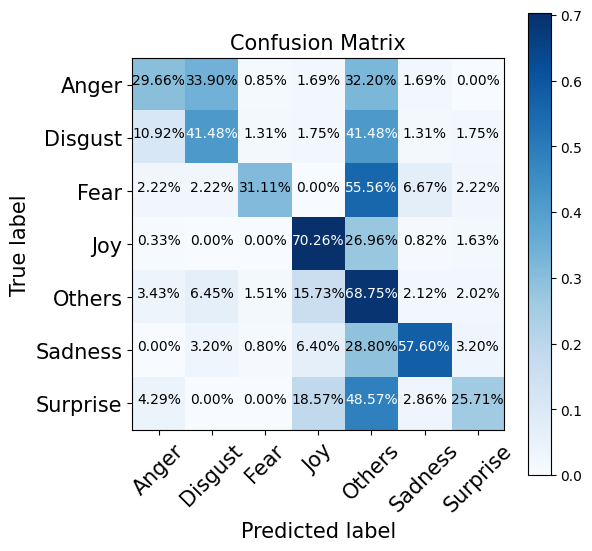

[[ 35  42   2   3  34   2   0]
 [ 22 107   4   4  87   3   2]
 [  2   0  13   2  24   3   1]
 [  2   0   0 452 143   6   9]
 [ 31  72   8 172 661  25  23]
 [  2   6   1  10  30  73   3]
 [  3   4   0  14  32   2  15]]


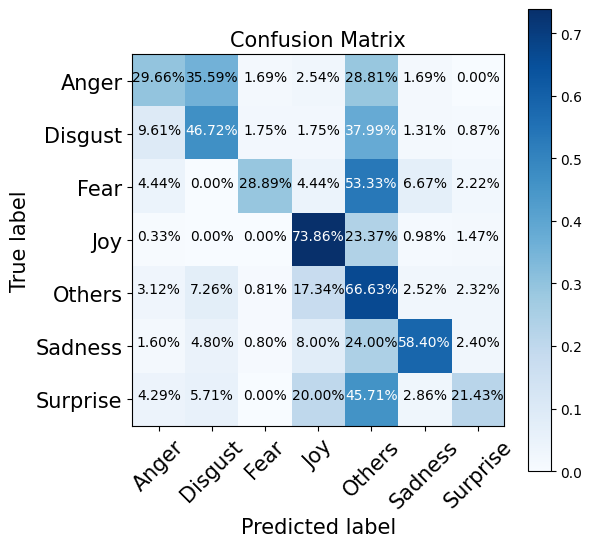

[[ 33  41   2   2  37   2   1]
 [ 15 108   4   3  89   3   7]
 [  0   2  16   1  24   2   0]
 [  3   0   1 424 171   5   8]
 [ 26  63   8 164 681  24  26]
 [  1   7   0   7  31  77   2]
 [  2   3   2  12  30   2  19]]


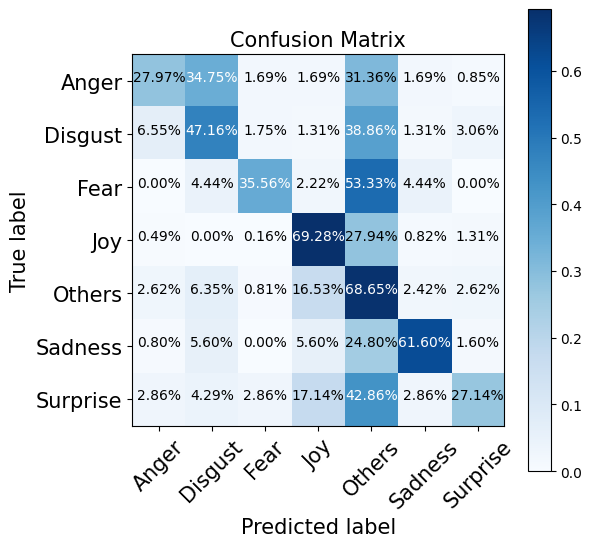

In [36]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(cm, classes, ax,
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=15)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=15)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j] * 100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)


for idx, result in enumerate(results):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = result['confusion_matrix_results']
    print(cm)
    plot_confusion_matrix(cm, ['Anger', 'Disgust', 'Fear', 'Joy', 'Others', 'Sadness', 'Surprise'], ax)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

Confusion matrix with decimal 

[[ 35  40   1   2  38   2   0]
 [ 25  95   3   4  95   3   4]
 [  1   1  14   0  25   3   1]
 [  2   0   0 430 165   5  10]
 [ 34  64  15 156 682  21  20]
 [  0   4   1   8  36  72   4]
 [  3   0   0  13  34   2  18]]


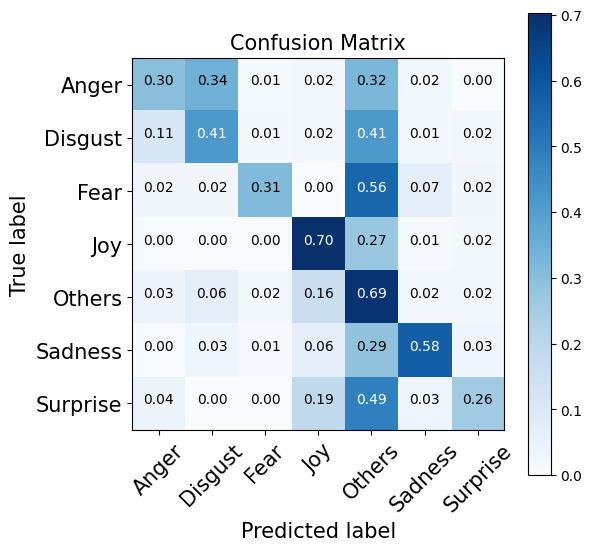

[[ 35  42   2   3  34   2   0]
 [ 22 107   4   4  87   3   2]
 [  2   0  13   2  24   3   1]
 [  2   0   0 452 143   6   9]
 [ 31  72   8 172 661  25  23]
 [  2   6   1  10  30  73   3]
 [  3   4   0  14  32   2  15]]


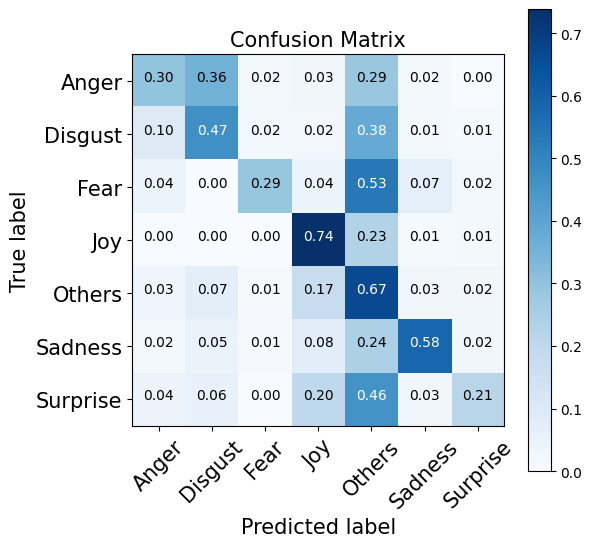

[[ 33  41   2   2  37   2   1]
 [ 15 108   4   3  89   3   7]
 [  0   2  16   1  24   2   0]
 [  3   0   1 424 171   5   8]
 [ 26  63   8 164 681  24  26]
 [  1   7   0   7  31  77   2]
 [  2   3   2  12  30   2  19]]


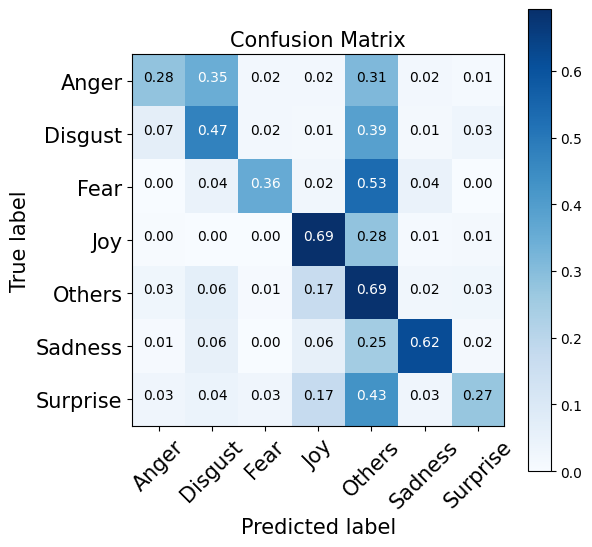

In [37]:
def plot_confusion_matrix_decimals(cm, classes, ax,
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=15)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=15)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    ax.set_ylabel('True label', fontsize=15)
    ax.set_xlabel('Predicted label', fontsize=15)

for idx, result in enumerate(results):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = result['confusion_matrix_results']
    print(cm)
    plot_confusion_matrix_decimals(cm, ['Anger', 'Disgust', 'Fear', 'Joy', 'Others', 'Sadness', 'Surprise'], ax)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()
